In [0]:
from fastai import *
from fastai.vision import *
from torchvision.models import *

In [0]:
%%capture

# upzipping dataset from google drive
!unzip "/content/drive/My Drive/CRISMIS_Dataset_v3.zip"

In [0]:
# defining datapath
path = Path('/content/CRISMIS_Dataset_v3') # Define path to the image folders

# creating a dataloader and applying transforms (augmentation to increase the test/valid size)
data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(do_flip=True, 
                                                         flip_vert=True, 
                                                         max_rotate=360.0, 
                                                         max_zoom=1.5, 
                                                         max_lighting=0.5, 
                                                         p_affine=0.75, 
                                                         p_lighting=0.75), 
                                  size=(256,256),
                                  resize_method=ResizeMethod.SQUISH,
                                  num_workers=4, 
                                  bs = 64) \
        .normalize(imagenet_stats)

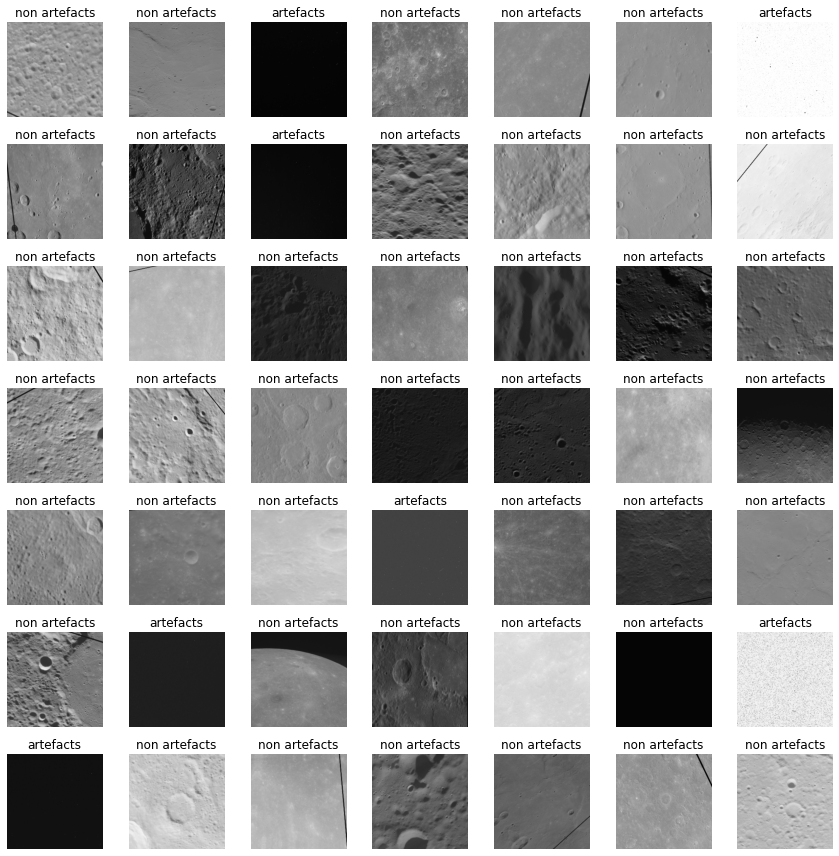

In [24]:
# visualisation of images in dataloader

data.show_batch(rows=7, figsize=(12, 12))

In [25]:
data.classes

['artefacts', 'non artefacts']

In [0]:
# creating a learner object (model) - pretrained resnet 152 which will be finetuned for this particular task

arch = resnet152 
def getLearner():
    return cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learn = getLearner()

epoch,train_loss,valid_loss,accuracy,time
0,0.413998,0.272389,0.928230,00:44
1,0.241875,0.139153,0.980861,00:44
2,0.207745,0.128086,0.980861,00:43
3,0.163553,0.127568,0.980861,00:43
4,0.133908,0.069205,0.983254,00:42
5,0.104626,0.049326,0.992823,00:43
6,0.077347,0.070294,0.995215,00:43
7,0.069690,0.049450,0.990431,00:43
8,0.057355,0.040553,0.990431,00:44
9,0.050046,0.041512,0.990431,00:44


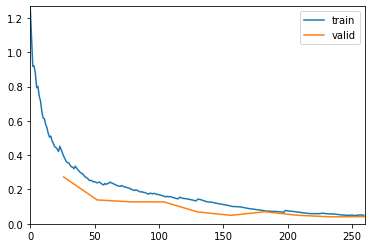

In [30]:
# unfreezing all the layers
learn.unfreeze()

# running for 5 epochs with auto-stop in case of overfitting
learn.fit_one_cycle(10)

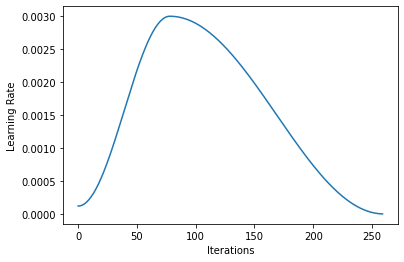

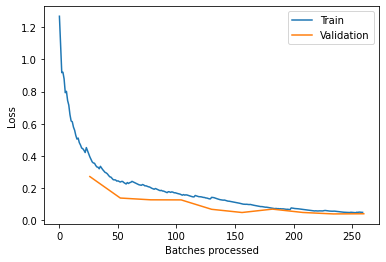

In [36]:
''' visualising the
    - variable learning rate
    - loss over iterations / batch iterations
'''


learn.recorder.plot_lr()
learn.recorder.plot_losses()


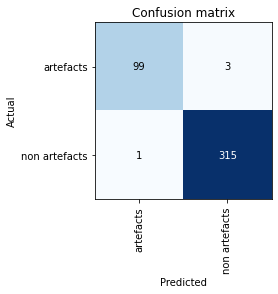

In [37]:
# Confusion matrix (showing excellent immunity for false positives and negatives)


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
# saving the .pth and .pkl files in the working directory

learn.export()
learn.save('version_1')

In [39]:
# the detailed model architecture

learn.load('version_1')

Learner(data=ImageDataBunch;

Train: LabelList (1675 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
non artefacts,non artefacts,non artefacts,non artefacts,non artefacts
Path: /content/CRISMIS_Dataset_v3;

Valid: LabelList (418 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
non artefacts,non artefacts,non artefacts,artefacts,non artefacts
Path: /content/CRISMIS_Dataset_v3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1)

In [40]:
preds,y, loss = learn.get_preds(with_loss=True)

# get accuracy
acc = accuracy(preds, y)

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)

In [41]:
# displaying the Model Accuracy and Area under the Curve

print('The accuracy is {0} %.'.format(acc*100))
print('ROC area is {0}'.format(roc_auc))

The accuracy is 99.04306030273438 %.
ROC area is 0.9990071978158352


## The accuracy is 99.04306030273438 %.
## ROC area is 0.9990071978158352

No handles with labels found to put in legend.


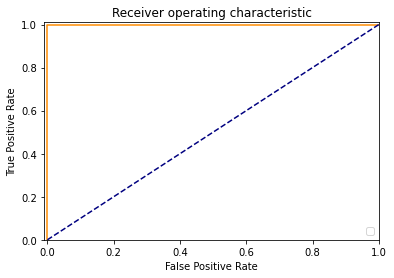

In [42]:
# plotting the AUROC (Area under ROC) graph

plt.figure()

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

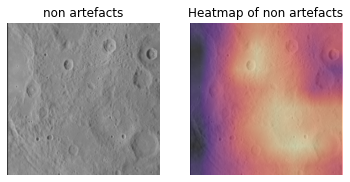

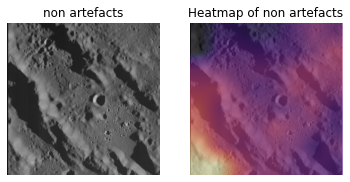

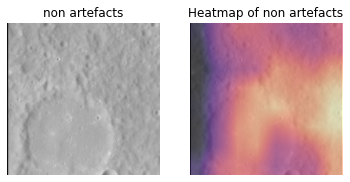

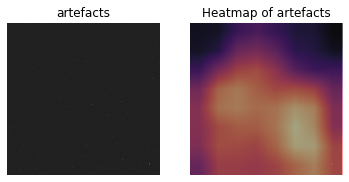

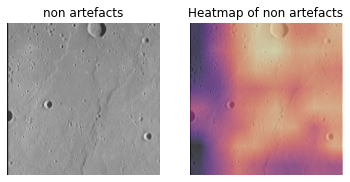

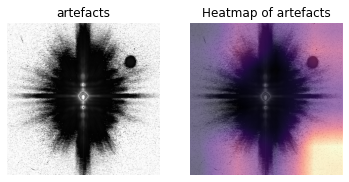

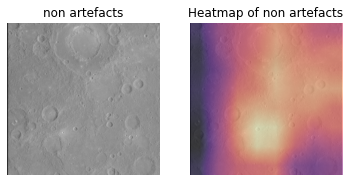

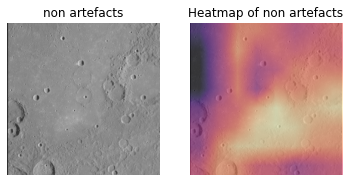

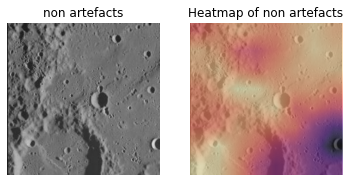

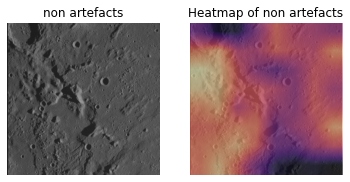

In [45]:
# callback implemented to view the areas of the image that triggered the classifier as a heatmap
from fastai.callbacks.hooks import *

def visualize_cnn_by_heatmap(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'Heatmap of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_heatmap(learn, idx)

In [46]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Mar 18 15:21:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |   2377MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  